In [1]:
!pip install seaborn

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import random
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib

In [3]:
import os
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

In [4]:
import sys
sys.path.append('.')

In [5]:
# import classifyGenericModified, model
# import importlib
# importlib.reload(classifyGenericModified)
# importlib.reload(model)
# from model import *
# from classifyGenericModified import ExperimentalClassifier, ExperimentalHybridClassifier, normalizeName

In [6]:
from classifyGenericModified import ExperimentalClassifier, ExperimentalHybridClassifier
import classifyGeneric
from model import *

In [7]:
dataset = pd.read_csv('../GenericClassifier_re_evaluation_2.txt', sep='\t', header=None,
                      names=['verified_label', 'label', '?', 'input'])
dataset['verified_label'] = dataset.verified_label.str.replace('VER_', '')

In [8]:
dataset.head()

,verified_label,label,?,input
0,SPE,SPE,1,(EMBL-EBI)
1,SPE,SPE,1,(GWC)2
2,SPE,SPE,1,‘Carol Davila’ University of Medicine and Phar...
3,GEN,SPE,1,20/20 Laboratory for Fuel Cells and Green Ener...
4,SPE,SPE,1,22 State University of New York at Albany


In [9]:
# test_2m = pd.read_csv('output/dataset-2M-noisy.test.csv')
test_200k = pd.read_csv('output/dataset-200k-noisy.test.csv')

In [10]:
len(test_200k)

90148

In [11]:
# test_2m['input'] = test_2m.input.fillna('')

In [12]:
# # take a small smale to speed up debugging
# _, test_2m = train_test_split(test_2m, test_size=0.01, stratify=test_2m.label)

In [13]:
from joblib import Parallel
parallel = Parallel(n_jobs=4, backend='multiprocessing', verbose=10)

In [14]:
def score(gold, preds, sample_weight=None):
    return precision_recall_fscore_support(gold, preds, sample_weight=sample_weight, labels=['GEN'])

def evaluate_classifier(c, name=None):
    tqdm.pandas(desc="classifying", position=0, leave=True)
    preds_col = c.name if hasattr(c, 'name') else name
    assert preds_col, 'Please give a name to your classifier'
    dataset[preds_col] = dataset.input.progress_apply(c.classifyOrg)
    print('Results on 7k dataset:', score(dataset.verified_label, dataset[preds_col]))
    tqdm.pandas(desc="classifying", position=0, leave=True)
    test_200k[preds_col] = test_200k.input.progress_apply(c.classifyOrg)
    print('Results on 200k dataset:', score(test_200k.label, test_200k[preds_col]))
    print('Results on 200k dataset (weighted):', score(test_200k.label, test_200k[preds_col], test_200k.numdocs))
    
def evaluate_classifier_batch(c, name=None):
    tqdm.pandas(desc="classifying", position=0, leave=True)
    preds_col = c.name if hasattr(c, 'name') else name
    assert preds_col, 'Please give a name to your classifier'
    dataset[preds_col] = c.classifyOrgBatch(dataset.input.values, parallel)
    print('Results on 7k dataset:', score(dataset.verified_label, dataset[preds_col]))
    test_200k[preds_col] = c.classifyOrgBatch(test_200k.input.values, parallel)
    print('Results on 200k dataset:', score(test_200k.label, test_200k[preds_col]))
    print('Results on 200k dataset (weighted):', score(test_200k.label, test_200k[preds_col], test_200k.numdocs))

# Run the original classifier

In [15]:
%%time
evaluate_classifier(classifyGeneric, 'orig')

classifying:   1%|          | 844/90148 [00:00<00:10, 8435.52it/s]

Results on 7k dataset: (array([0.79864061]), array([0.92519685]), array([0.85727314]), array([4064]))


classifying: 100%|██████████| 90148/90148 [00:08<00:00, 10299.93it/s]


Results on 200k dataset: (array([0.30515353]), array([0.93814365]), array([0.46051395]), array([15148]))
Results on 200k dataset (weighted): (array([0.66182195]), array([0.98014662]), array([0.79012785]), array([22507348.]))
CPU times: user 10.9 s, sys: 112 ms, total: 11 s
Wall time: 11 s


# Run the modified classifier

We will start with a classifier without any new features, and with acronym rule disabled and the add features one by one:

- modified acronym rule
- multilingual word lists
- US zipcode rule

In [16]:
# # use this if you need to reload
# import importlib
# import classifyGenericModified
# importlib.reload(classifyGenericModified)
# from classifyGenericModified import ExperimentalClassifier

## Without acronym rule or multilingual word lists

In [17]:
conf = {
   'use_acronym_rule': False, 
   'use_multilingual_dicts': False, 
   'use_zipcode_us_rule': False
}
cl_mod = ExperimentalClassifier('modified', use_approx_subj_dict=True, **conf)

Loading dictionary...


generating approximate dict: 100%|██████████| 15210/15210 [00:06<00:00, 2420.52it/s]


Loading dictionary done in 7.01 sec.


In [18]:
%%time
evaluate_classifier(cl_mod)

classifying:   1%|          | 807/90148 [00:00<00:11, 8040.50it/s]

Results on 7k dataset: (array([0.72037743]), array([0.97687008]), array([0.82924282]), array([4064]))


classifying: 100%|██████████| 90148/90148 [00:08<00:00, 11009.65it/s]


Results on 200k dataset: (array([0.30255334]), array([0.97075522]), array([0.4613261]), array([15148]))
Results on 200k dataset (weighted): (array([0.65493709]), array([0.99168667]), array([0.7888777]), array([22507348.]))
CPU times: user 10.3 s, sys: 123 ms, total: 10.5 s
Wall time: 10.6 s


In [19]:
del cl_mod # free up memory

## Adding modified acronym rule

In [20]:
conf['use_acronym_rule'] = True
cl_acronym = ExperimentalClassifier('+ acronym rule', use_approx_subj_dict=True, **conf)

Loading dictionary...


generating approximate dict: 100%|██████████| 15210/15210 [00:07<00:00, 2112.12it/s]


Loading dictionary done in 8.18 sec.


In [21]:
%%time
evaluate_classifier(cl_acronym)

classifying:   3%|▎         | 2344/90148 [00:00<00:07, 11549.49it/s]

Results on 7k dataset: (array([0.73730893]), array([0.96136811]), array([0.83456157]), array([4064]))


classifying: 100%|██████████| 90148/90148 [00:08<00:00, 10817.27it/s]


Results on 200k dataset: (array([0.3085169]), array([0.9689728]), array([0.46801862]), array([15148]))
Results on 200k dataset (weighted): (array([0.66058169]), array([0.99156378]), array([0.79291913]), array([22507348.]))
CPU times: user 10.4 s, sys: 100 ms, total: 10.5 s
Wall time: 10.5 s


In [22]:
del cl_acronym # free up memory

## With multilingual multilingual word lists

In [23]:
conf['use_multilingual_dicts'] = True
cl_multiling = ExperimentalClassifier('+ multilingual', use_approx_subj_dict=True, **conf)

Loading dictionary...


generating approximate dict: 100%|██████████| 50434/50434 [00:27<00:00, 1842.37it/s]


Loading dictionary done in 28.59 sec.


In [24]:
%%time
evaluate_classifier(cl_multiling)

classifying:   1%|▏         | 1187/90148 [00:00<00:14, 5982.42it/s]

Results on 7k dataset: (array([0.73772659]), array([0.96136811]), array([0.83482906]), array([4064]))


classifying: 100%|██████████| 90148/90148 [00:16<00:00, 5628.12it/s]


Results on 200k dataset: (array([0.30918627]), array([0.9689728]), array([0.46878843]), array([15148]))
Results on 200k dataset (weighted): (array([0.66075474]), array([0.99154405]), array([0.79303748]), array([22507348.]))
CPU times: user 18.7 s, sys: 218 ms, total: 18.9 s
Wall time: 19.1 s


In [25]:
del cl_multiling # free up memory

## With US zipcode rule (added mainly for grant org strings)

In [26]:
conf['use_zipcode_us_rule'] = True
cl_us_zipcode = ExperimentalClassifier('+ us zipcode', use_approx_subj_dict=True, **conf)

Loading dictionary...


generating approximate dict: 100%|██████████| 50434/50434 [00:25<00:00, 1943.58it/s]


Loading dictionary done in 27.15 sec.


In [27]:
%%time
evaluate_classifier(cl_us_zipcode)

classifying:   1%|▏         | 1213/90148 [00:00<00:15, 5872.52it/s]

Results on 7k dataset: (array([0.73772659]), array([0.96136811]), array([0.83482906]), array([4064]))


classifying: 100%|██████████| 90148/90148 [00:14<00:00, 6413.88it/s]


Results on 200k dataset: (array([0.30918627]), array([0.9689728]), array([0.46878843]), array([15148]))
Results on 200k dataset (weighted): (array([0.66075474]), array([0.99154405]), array([0.79303748]), array([22507348.]))
CPU times: user 16.8 s, sys: 159 ms, total: 17 s
Wall time: 17 s


In [28]:
del cl_us_zipcode # free up memory

## Hybrid classifier: rule+SVM

In [29]:
%%time
cl_hybrid_linear = joblib.load('output/hybrid_classifier-linear-trained_on_100k.pkl')

CPU times: user 10.6 s, sys: 1.09 s, total: 11.7 s
Wall time: 11.9 s


In [30]:
%%time
evaluate_classifier_batch(cl_hybrid_linear, 'hybrid-linear')

Results on 7k dataset: (array([0.96942242]), array([0.63188976]), array([0.76508268]), array([4064]))


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    3.7s remaining:    1.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.7s remaining:    1.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.6s finished


Results on 200k dataset: (array([0.83676208]), array([0.86460259]), array([0.85045455]), array([15148]))
Results on 200k dataset (weighted): (array([0.96690314]), array([0.86426104]), array([0.91270539]), array([22507348.]))
CPU times: user 16.8 s, sys: 2.83 s, total: 19.7 s
Wall time: 25.5 s


In [31]:
del cl_hybrid_linear # free up memory

In [32]:
%%time
cl_hybrid_linear_weighted = joblib.load('output/hybrid_classifier-linear-weighted-trained_on_100k.pkl')

CPU times: user 909 ms, sys: 21.2 ms, total: 930 ms
Wall time: 936 ms


In [33]:
%%time
evaluate_classifier_batch(cl_hybrid_linear_weighted, 'hybrid-linear-weighted')

Results on 7k dataset: (array([0.84447087]), array([0.87376969]), array([0.85887048]), array([4064]))


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    3.7s remaining:    1.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.9s remaining:    1.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.8s finished


Results on 200k dataset: (array([0.49336664]), array([0.96481384]), array([0.65287798]), array([15148]))
Results on 200k dataset (weighted): (array([0.82161308]), array([0.99023492]), array([0.8980775]), array([22507348.]))
CPU times: user 6.81 s, sys: 657 ms, total: 7.47 s
Wall time: 13.7 s


In [34]:
del cl_hybrid_linear_weighted # free up memory

# Examine predictions on 200k dataset

In [35]:
test_sample = test_200k

## Check org strings predicted to be specific

In [36]:
cl_col = 'hybrid-linear-weighted'

In [37]:
spe_predicted = (test_sample[test_sample[cl_col] == 'SPE']
                 [['input', 'label', cl_col, 'id']].sample(frac=1, random_state=132))

In [38]:
spe_predicted.iloc[:20]

,input,label,hybrid-linear-weighted,id
68002,Quisisana Hospital,SPE,SPE,NaN
37190,Hazara University Mansehra,SPE,SPE,NaN
49515,Methodist Rehabilitation Center,SPE,SPE,NaN
37037,Ibdml,SPE,SPE,NaN
27507,Boston University Medical Center,SPE,SPE,NaN
9101,Inst. De Cardiologie De Montreal,SPE,SPE,NaN
18696,Flagler College,SPE,SPE,NaN
23987,National Institute Of Hygiene,SPE,SPE,NaN
60879,University Of The Basque Country,SPE,SPE,NaN
40354,Council Of Scientific And Industrial Research,SPE,SPE,NaN


In [39]:
spe_predicted.iloc[20:40]

,input,label,hybrid-linear-weighted,id
62419,"Evimed Research Group, Llc",SPE,SPE,NaN
51322,University Malaysia,SPE,SPE,NaN
35465,Istanbul Kültür University,SPE,SPE,NaN
74708,Exxonmobil Development Company,SPE,SPE,NaN
71992,Muğla Sıtkı Kocman University,SPE,SPE,NaN
15057,IROB Group,GEN,SPE,60115484.0
79995,Institut Für Pharmazeutische Biologie,SPE,SPE,NaN
49098,Inserm U657,SPE,SPE,NaN
78360,Royal College Of Surgeons In Ireland,SPE,SPE,NaN
1352,Centro De Investigacion Cientifica Y De Educac...,SPE,SPE,NaN


In [40]:
spe_predicted.iloc[40:60]

,input,label,hybrid-linear-weighted,id
4688,Rio Cuarto National University,SPE,SPE,NaN
7242,Hofstra University,SPE,SPE,NaN
68222,Medicinska fakulteten,GEN,SPE,60016774.0
28312,Tadulako University,SPE,SPE,NaN
10369,Mitsubishi Cable Industries Ltd.,SPE,SPE,NaN
25752,Lutheran General Children's Hospital,SPE,SPE,NaN
74415,Realtek Semiconductor Corp.,SPE,SPE,NaN
49192,Hospital Santojanni,SPE,SPE,NaN
19520,University Of Gorakhpur,SPE,SPE,NaN
52464,Gansu Provincial Center For Disease Control An...,SPE,SPE,NaN


## Sample some correct predictions

In [41]:
correct = (test_sample[test_sample[cl_col] == test_sample['label']][['input', 'label', cl_col]])
_, correct = train_test_split(correct, test_size=0.1, stratify=correct.label)

In [42]:
correct.head(20)

,input,label,hybrid-linear-weighted
59166,Dipto. di Chim. Inorg.,GEN,GEN
23813,Izmiran,SPE,SPE
9280,Hospital San Jaime,SPE,SPE
8197,Med. Inst.,SPE,SPE
28640,American Studies,GEN,GEN
79862,Département de Psychiatrie,GEN,GEN
40347,Pula General Hospital,SPE,SPE
85608,Klinikum Krefeld,SPE,SPE
29479,Universita' Di Trieste,SPE,SPE
30348,Poole Hospital,SPE,SPE


## Examine errors

In [43]:
errors = (test_sample[test_sample[cl_col] != test_sample['label']]
             [['input', 'label', cl_col, 'id']].sample(frac=1, random_state=3295))
errors.iloc[:20]

,input,label,hybrid-linear-weighted,id
71593,Icar-national Institute Of Abiotic Stress Mana...,SPE,GEN,NaN
36824,University Medical Laser Centre,GEN,SPE,60119746.0
19511,Academic Hospital,SPE,GEN,NaN
8870,Klinik Im Park,SPE,GEN,NaN
13579,Faculty Of Science And Technology,SPE,GEN,NaN
26860,Ministry Of Agriculture,SPE,GEN,NaN
1473,The Institute For Advanced Study,SPE,GEN,NaN
66055,Dipartimento Di Astronomia,SPE,GEN,NaN
43160,Bureau Of Chemistry,SPE,GEN,NaN
47267,Wil Research,SPE,GEN,NaN


In [44]:
errors.iloc[20:40]

,input,label,hybrid-linear-weighted,id
48014,Wildlife Conservation Society,SPE,GEN,NaN
24075,St. Xavier's College,SPE,GEN,NaN
89303,MGSE,GEN,SPE,60118512.0
21941,Nerc Inst. Virol. Environ. M.,SPE,GEN,NaN
77564,Qld Department Of Primary Industries,SPE,GEN,NaN
3179,Kakioka Magnetic Observatory,SPE,GEN,NaN
44880,Centre For Applied Nursing Research,SPE,GEN,NaN
39392,State Water Resources Control Board,SPE,GEN,NaN
74747,Austrian Research Centers,SPE,GEN,NaN
19084,University Hospital 3465,SPE,GEN,NaN


In [45]:
errors.iloc[40:60]

,input,label,hybrid-linear-weighted,id
3375,Modern Materials Handling,SPE,GEN,NaN
12872,Faculte Des Sciences,SPE,GEN,NaN
38159,Zhengzhou College Of Animal Husbandry Engineering,SPE,GEN,NaN
86005,Inst. Gruzl.,SPE,GEN,NaN
447,Faculté De Médecine Laënnec,SPE,GEN,NaN
59149,Facultad De Ciencias Exactas Y Tecnología,SPE,GEN,NaN
45546,Center For Musculoskeletal Research,SPE,GEN,NaN
83732,Nuclear Research Centre,SPE,GEN,NaN
83181,Department Of Health Of Moscow,SPE,GEN,NaN
16644,Catharina-ziekenhuis,SPE,GEN,NaN


In [46]:
errors_sorted = errors.sort_values('id')
errors_sorted.iloc[200:220]

,input,label,hybrid-linear-weighted,id
26409,State Key Laboratory of Coordinate Chemistry,GEN,SPE,60073599.0
25555,Inst. of Soil Sci. and Plant Nutr.,GEN,SPE,60073761.0
42804,Christ's College,GEN,SPE,60079645.0
6333,Christ’s College,GEN,SPE,60079645.0
82040,CIRIST'S COLLEGE,GEN,SPE,60079645.0
49107,IRC in Su 3Erconductivity,GEN,SPE,60081454.0
85147,Res. Ctr. for Engl. and Appl. Ling.,GEN,SPE,60081623.0
43966,International Coastal Research Center,GEN,SPE,60081731.0
25084,Research Institute of Mathematical Sciences (R...,GEN,SPE,60082699.0
34359,Wojsk. Inst.,GEN,SPE,60087273.0


In [47]:
errors_sorted.iloc[390:410]

,input,label,hybrid-linear-weighted,id
61947,Sedgwick Museum,GEN,SPE,60119738.0
81845,Sedgwick Muesum,GEN,SPE,60119738.0
59717,Museum Archaeology/Anthropology,GEN,SPE,60119744.0
36824,University Medical Laser Centre,GEN,SPE,60119746.0
64117,Aero-Acoust. Noise Contr. L.,GEN,SPE,60119752.0
54032,Asia Centre,GEN,SPE,60119781.0
70390,Institute for Molecular Biology and Genetics (...,GEN,SPE,60119800.0
7665,Institute of Molecular Biology and Genetics (I...,GEN,SPE,60119800.0
61415,University Museum,GEN,SPE,60119827.0
21278,FSERC,GEN,SPE,60119828.0


## How much do multilingual dicts change the results?

In [48]:
test_sample['changed_by_multiling'] = (test_sample['+ acronym rule'] != test_sample['+ multilingual'])

In [49]:
test_sample['changed_by_multiling'].mean()

0.0017415805120468563

In [50]:
test_sample[test_sample['+ acronym rule']=='GEN'].changed_by_multiling.value_counts()

False    47446
True       130
Name: changed_by_multiling, dtype: int64

In [51]:
test_sample[test_sample['+ acronym rule']=='SPE'].changed_by_multiling.value_counts()

False    42545
True        27
Name: changed_by_multiling, dtype: int64

## How much do machine learning models change the results?

In [52]:
test_sample['changed_by_hybrid'] = (test_sample[cl_col] != test_sample['+ multilingual'])

In [53]:
test_sample[test_sample['+ multilingual']=='GEN'].changed_by_hybrid.value_counts()

False    26480
True     20993
Name: changed_by_hybrid, dtype: int64

In [54]:
test_sample[test_sample['+ multilingual']=='SPE'].changed_by_hybrid.value_counts()

False    39532
True      3143
Name: changed_by_hybrid, dtype: int64

## Distribution of 2 classes

In [55]:
test_sample.columns

Index(['input', 'id', 'label', 'numdocs', 'orig', 'modified', '+ acronym rule',
       '+ multilingual', '+ us zipcode', 'hybrid-linear',
       'hybrid-linear-weighted', 'changed_by_multiling', 'changed_by_hybrid'],
      dtype='object')

In [56]:
systems = ['silver_standard', 'orig', 'modified', 
           '+ acronym rule', '+ multilingual', '+ us zipcode',
           'hybrid-linear', 'hybrid-linear-weighted']
test_sample_melt = (test_sample.rename(columns={'label': 'silver_standard'})
                    .melt(id_vars='input', value_vars=systems, var_name='system', value_name='label'))

In [57]:
counts_by_system = test_sample_melt.groupby(['system', 'label'])['input'].count().unstack('label')

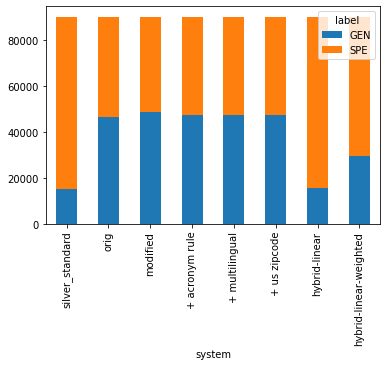

In [58]:
_ = counts_by_system.loc[systems].plot.bar(stacked=True)

In [66]:
(counts_by_system.loc['hybrid-linear'] - counts_by_system.loc['silver_standard'])/len(test_sample)

label
GEN    0.005591
SPE   -0.005591
dtype: float64

# Measure feature overhead

In [61]:
feature_extractor = joblib.load('output/feature_extractor-linear.pkl')

In [62]:
hybrid_classifier = joblib.load('output/hybrid_classifier-linear-weighted.pkl')

In [63]:
test_200k['preprocessed_input'] = test_200k.input.apply(hybrid_classifier.rule_classifier.preprocess)
test_200k['rule_predictions'] = test_200k.preprocessed_input.apply(hybrid_classifier._apply_rules)

In [64]:
features = feature_extractor.transform((test_200k.input, test_200k.rule_predictions))

ValueError: operands could not be broadcast together with shapes (90148,11) (13,) 

In [ ]:
print('Max number of features:', features.shape[1])

In [ ]:
nnz_by_row = [features[i].getnnz() for i in range(features.shape[0])]

In [ ]:
print('Actual number of features: %.2f (std=%.2f)' %(np.mean(nnz_by_row), np.std(nnz_by_row)))

In [ ]:
density = features.getnnz() / np.prod(features.shape)
print('Density:', density)